# Тестовое задание

**Общие требования:**
1. приложить файл requirements.txt с пакетами, которые необходимо установить для воспроизведения результата.
1. комментировать ход решения.
1. **дополнительный вопрос на подумать (к каждой задаче):** есть ли метрики, которые лучше подходят для задачи?
1. **дополнительное вопрос на подумать (к каждой задаче):** как изменилось бы решение, если бы модель необходимо было встроить в другую систему, используя Java?

**Критерии оценки:** 
1. Владение инструментами анализа данных и машинного обучения.
1. Финальное качество, которые удалось получить.

Намного важнее **как** вы решаете задачу, чем финальная метрика на тесте.

# 1. Задания 

## 1.1 Классификация и регрессия

#### Данные

Источник данных: http://cas.uqam.ca/. Авторы: Christophe Dutang, Arthur Charpentier. Лицензия: GPL-3. Некоторые столбцы были модифицированны, чтобы не возникало искушение подсмотреть целевые переменные в исходном датасете. Данные находятся в приложенном файле *task1_train_v5.csv*

**Задача:**

1. для заданного набора данных (*task1_train_v5.csv*) решить задачи классификации (целевая переменная *target_classification*, метрика ROC-AUC) и регрессии (целевая переменная *target_regression*, метрика RMSE).
2. получить предсказания для тестового набора данных (*task1_test_v5.csv*), сохранить в файл с расширением *csv* и приложить к решению

## 1.2 Кластеризация

1. кластеризовать заданный набор данных (*task2_train_v5.csv*). Предложить метрику и проверить качество.
2. получить предсказания (номер кластера), сохранить в файл с расширением *csv* и приложить к решению.

In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier   
from sklearn.neighbors import KNeighborsRegressor   
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from sklearn import datasets
from sklearn.manifold import TSNE

In [2]:
%matplotlib inline
pd.options.display.max_rows=1000

# 1.1.1. Preprocessing

In [442]:
# Data loading
task1_train = pd.read_csv('task1_train_v5.csv', sep=';')
task1_test = pd.read_csv('task1_test_v5.csv', sep=';')
task2_data = pd.read_csv('task2_v5.csv', sep=';')

print('shape 1: ', task1_train.shape)
print('shape 2: ', task1_test.shape)
print('shape 3: ', task2_data.shape)

shape 1:  (339006, 13)
shape 2:  (339007, 11)
shape 3:  (870, 4)


In [443]:
# Function to calculate missing values in columns
def missing_values_table(df):
        # Total missing values in each column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [444]:
# To see if we can drop missing values like NaNs. 10% of values is not critical
missing_values_table(task1_train)

Your selected dataframe has 13 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
Exposure,33900,10.0
Area,33900,10.0
VehPower,33900,10.0
VehAge,33900,10.0
DrivAge,33900,10.0
BonusMalus,33900,10.0
VehBrand,33900,10.0
VehGas,33900,10.0


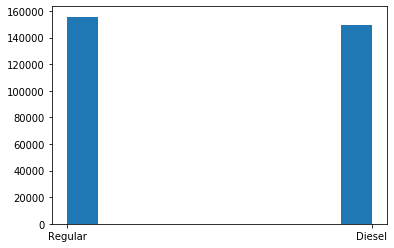

C:\Users\r_mam\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,target_regression,target_classification
0,1124750,0.740000,C,5.0,10.0,50.0,50.0,B2,Regular,182.0,R82,0.00,0
1,516531,0.780000,C,6.0,5.0,40.0,50.0,NaN,Diesel,262.0,R93,0.00,0
2,922566,1.000000,E,4.0,12.0,33.0,50.0,B3,Diesel,3103.0,R82,0.00,0
3,335537,0.528169,D,4.0,16.0,40.0,100.0,B2,Regular,1313.0,R24,0.00,0
4,1355191,0.340000,B,7.0,7.0,42.0,156.0,B5,Regular,57.0,R24,0.00,0
5,1844262,0.760000,D,6.0,0.0,40.0,50.0,B4,Regular,1326.0,R93,0.00,0
6,905760,0.528169,D,5.0,5.0,44.0,51.0,B4,Diesel,1313.0,R24,0.00,0
7,687805,0.540000,F,5.0,2.0,58.0,50.0,B12,Regular,27000.0,R11,0.00,0
8,365938,0.010000,D,5.0,0.0,72.0,50.0,B2,Regular,581.0,R82,0.00,0
9,790912,0.080000,A,4.0,18.0,26.0,80.0,B1,Regular,8.0,R72,0.00,0


In [445]:
# Filling missing numerical data with mean values. We can also fill categorial features
task1_train = task1_train.fillna(task1_train.mean())
int_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus']

# Making integers from floats
task1_train[int_features] = task1_train[int_features].round(0)

# This feature is uniformly distributed. So we can replace NaNs in this column
plt.hist(task1_train['VehGas'].dropna())
plt.title('VehGas')
plt.show()

# Filling the 'VehGas' feature. Other categoricals won't be replaced
indices = task1_train[task1_train['VehGas'].isna()].sample(frac=0.5).index
task1_train['VehGas'][indices]='Diesel'
task1_train.VehGas = task1_train.VehGas.fillna('Regular')
task1_train.head(100)

In [446]:
# Dropping all NaNs and the 1st column, reindexing the table
task1_train = task1_train.dropna().reset_index(drop=True).drop(columns=['IDpol'])
print('Data shape: ', task1_train.shape)

# Just to make sure all columns match data types
print(task1_train.dtypes)
task1_train.head()

shape:  (274582, 12)
Exposure                 float64
Area                      object
VehPower                 float64
VehAge                   float64
DrivAge                  float64
BonusMalus               float64
VehBrand                  object
VehGas                    object
Density                  float64
Region                    object
target_regression        float64
target_classification      int64
dtype: object


,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,target_regression,target_classification
0,0.740000,C,5.0,10.0,50.0,50.0,B2,Regular,182.0,R82,0.0,0
1,1.000000,E,4.0,12.0,33.0,50.0,B3,Diesel,3103.0,R82,0.0,0
2,0.528169,D,4.0,16.0,40.0,100.0,B2,Regular,1313.0,R24,0.0,0
3,0.340000,B,7.0,7.0,42.0,156.0,B5,Regular,57.0,R24,0.0,0
4,0.760000,D,6.0,0.0,40.0,50.0,B4,Regular,1326.0,R93,0.0,0


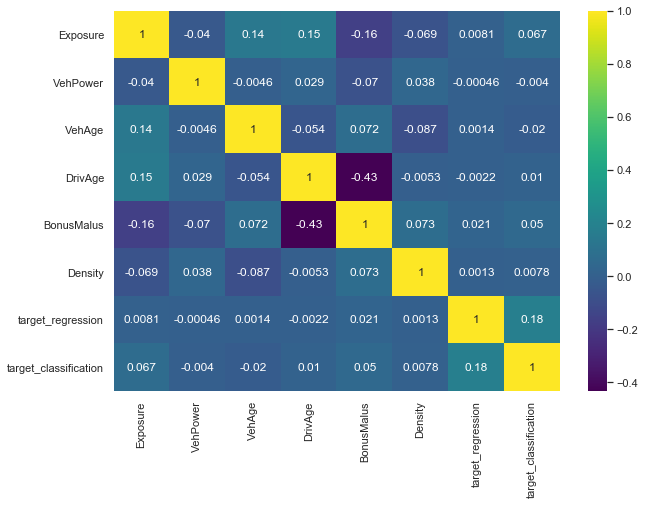

In [447]:
# To see hidden correlations in order to leave one feature only. Obviously, BonusMalus(Insurance) and DrivAge have a little connection, 
# but we will keep them both anyway
sns.set(rc={'figure.figsize':(10,7)})
sns.heatmap(task1_train.corr(), cmap='viridis', annot=True)

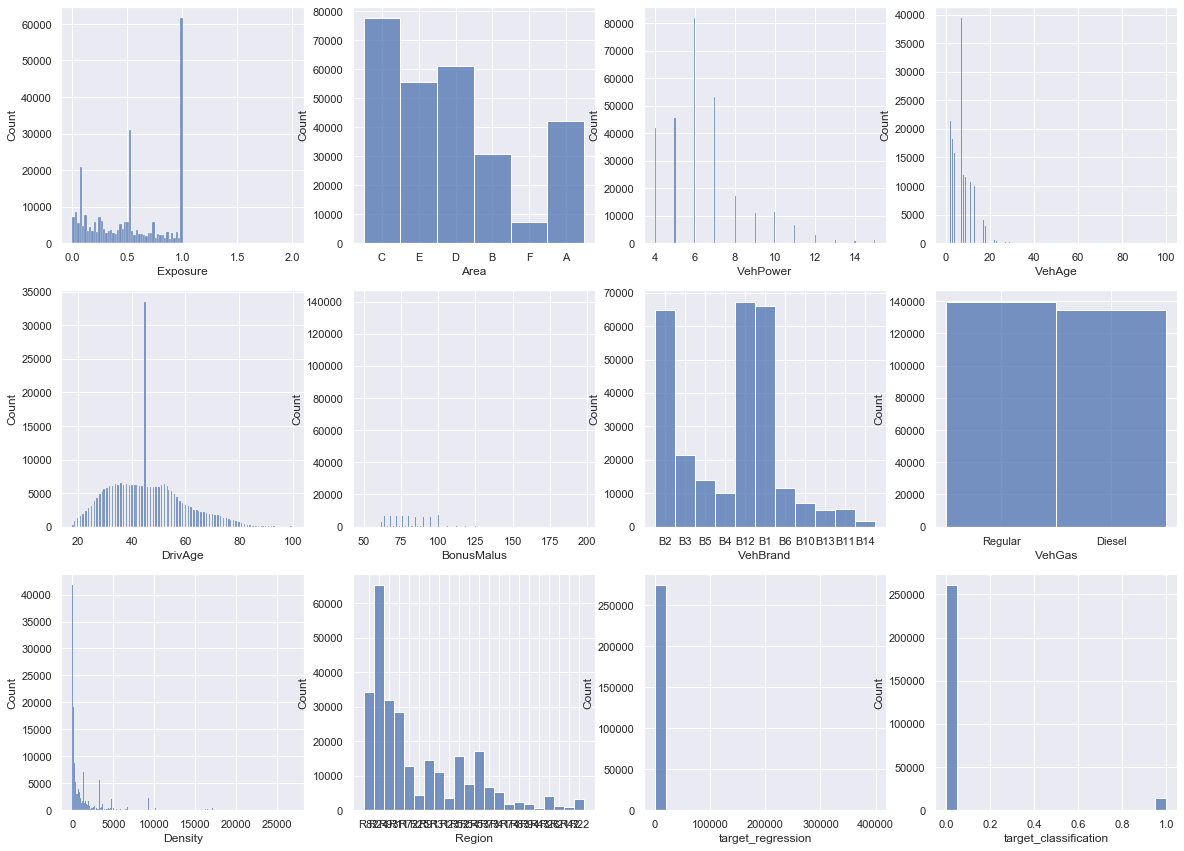

In [448]:
# To see if there are anomalies in features distributions
figure(figsize=(20, 20))
for i, column in enumerate(task1_train.columns, 1):
    plt.subplot(4,4,i)
    sns.histplot(data=task1_train[column])

In [456]:
# First, we choose categorical, numerical and target columns separately for train dataset
target_subset = task1_train[['target_regression', 'target_classification']]
numeric_subset = task1_train.drop(target_subset, axis=1).select_dtypes('number')
numeric_columns = numeric_subset.columns

# To add normalization to numerical features
sc = StandardScaler()
numeric_subset = pd.DataFrame(sc.fit_transform(numeric_subset), columns=numeric_columns)
print('Numerical subset shape: ', numeric_subset.shape)

# To convert categorical features into numerical
# Binary feature into [0,1]
label_encoder = LabelEncoder()
binary_subset = pd.DataFrame(label_encoder.fit_transform(task1_train['VehGas']), columns=['VehGas'])
print('Binary subset shape: ', binary_subset.shape)

# Multiclass features into N additional binary features with [0,1] values
categorical_subset = pd.get_dummies(task1_train[['Region', 'Area', 'VehBrand']])
print('Categorial subset shape: ', categorical_subset.shape)
print('Target subset shape: ', target_subset.shape)

# Concatenating all subsets
task1_train = pd.concat([categorical_subset.reset_index(drop=True),binary_subset.reset_index(drop=True), 
                         numeric_subset.reset_index(drop=True), target_subset.reset_index(drop=True)], axis=1)
task1_train.head(5)

Numerical subset shape:  (274582, 6)
Binary subset shape:  (274582, 1)
Categorial subset shape:  (274582, 39)
Target subset shape:  (274582, 2)


,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,...,VehBrand_B6,VehGas,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,target_regression,target_classification
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0.613028,-0.724489,0.547974,0.339556,-0.659192,-0.407262,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1.365694,-1.239098,0.919848,-0.927615,-0.659192,0.335010,0.0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,1,-0.000195,-1.239098,1.663597,-0.405839,2.702249,-0.119857,0.0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,1,-0.544920,0.304730,-0.009838,-0.256760,6.467063,-0.439026,0.0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0.670926,-0.209879,-1.311398,-0.405839,-0.659192,-0.116553,0.0,0


# 1.1.2. Classification

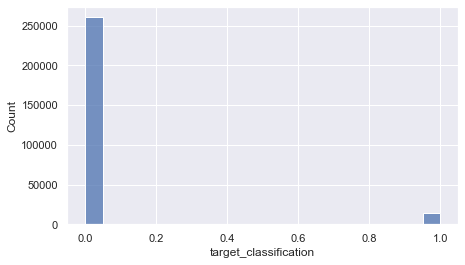

In [457]:
# We see disbalanced classes
sns.set(rc={'figure.figsize':(7,4)})
sns.histplot(data=task1_train['target_classification'])
plt.show()

In [458]:
# We struggle with disbalanced classes by reducing dominating one - undersampling
class_1 = task1_train[task1_train['target_classification']==0].sample(frac=0.1) # Dominating class
class_2 = task1_train[task1_train['target_classification']==1]                  # Rare class
print('Length of 1st class', len(class_1))
print('Length of 2st class', len(class_2))

# After we removed some amount of sampling for the 1st class, we concatenate data
task1_train_class = class_1.append(class_2,ignore_index=True).sample(frac=1).reset_index(drop=True)

# To divide data into train and val to check performance. We won't use cross-validation
X_train, X_val, y_train, y_val = train_test_split(task1_train_class.iloc[:,0:-2], task1_train_class['target_classification'], test_size=0.2)
print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
X_train.head()

Length of 1st class 26072
Length of 2st class 13866
Train data shape:  (31950, 46)
Validation data shape:  (7988, 46)


,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,...,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
19381,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0.757772,0.304730,-0.009838,-0.778536,1.155986,-0.381850
23579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.631766,2.363168,-1.311398,-0.554918,0.013097,-0.068271
13776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-0.255433,-0.209879,-1.311398,-0.480378,-0.659192,0.497899
31839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-1.384432,2.363168,-0.009838,-0.107681,-0.659192,-0.354914
16992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1.365694,-0.209879,0.733911,2.575739,-0.659192,-0.333314


In [461]:
# KNN classififer to train a model. n_neighbors = 3/5 are also good...
KNN_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski',weights='uniform')
KNN_model.fit(X_train, y_train)

# Here we make a prediction of the train data to estimate our model
KNN_prediction = KNN_model.predict(X_train)
print('Scores for train data:')
print('ROC AUC score: ', roc_auc_score(y_train, KNN_prediction))
print('f1 score: ', f1_score(y_train,KNN_prediction))
print('precision score: ', precision_score(y_train,KNN_prediction))
print('recall score: ', recall_score(y_train,KNN_prediction))
print('confusion matrix: ', confusion_matrix(y_train,KNN_prediction))

print('\nScores for validation data:')
KNN_prediction = KNN_model.predict(X_val)
print('ROC AUC score: ', roc_auc_score(y_val, KNN_prediction))
print('f1 score: ', f1_score(y_val,KNN_prediction))
print('precision score: ', precision_score(y_val,KNN_prediction))
print('recall score: ', recall_score(y_val,KNN_prediction))
print('confusion matrix: ', confusion_matrix(y_val,KNN_prediction))

Scores for train data:
ROC AUC score:  0.6880730218657717
f1 score:  0.5765013054830287
precision score:  0.6803894983360039
recall score:  0.5001359064963306
confusion matrix:  [[18320  2593]
 [ 5517  5520]]

Scores for validation data:
ROC AUC score:  0.5455128195904695
f1 score:  0.3600750156282559
precision score:  0.4385786802030457
recall score:  0.3054082714740191
confusion matrix:  [[4053 1106]
 [1965  864]]


In [462]:
# Random Forest classififer to train a model
RF_model = RandomForestClassifier(200,min_samples_leaf=4)
RF_model.fit(X_train, y_train)

## Here we make a prediction of the train data to estimate our model
RF_prediction = RF_model.predict(X_train)
print('Scores for train data:')
print('ROC AUC score: ', roc_auc_score(y_train, RF_prediction))
print('f1 score: ', f1_score(y_train, RF_prediction))
print('precision score: ', precision_score(y_train, RF_prediction))
print('recall score: ', recall_score(y_train, RF_prediction))
print('confusion matrix: ', confusion_matrix(y_train,RF_prediction))

print('\nScores for validation data:')
RF_prediction = RF_model.predict(X_val)
print('ROC AUC score: ', roc_auc_score(y_val, RF_prediction))
print('f1 score: ', f1_score(y_val,RF_prediction))
print('precision score: ', precision_score(y_val,RF_prediction))
print('recall score: ', recall_score(y_val,RF_prediction))
print('confusion matrix: ', confusion_matrix(y_val,RF_prediction))

Scores for train data:
ROC AUC score:  0.7004875893317306
f1 score:  0.5766664588139926
precision score:  0.9248
recall score:  0.41895442602156385
confusion matrix:  [[20537   376]
 [ 6413  4624]]

Scores for validation data:
ROC AUC score:  0.5748311506055133
f1 score:  0.31666666666666665
precision score:  0.6610549943883277
recall score:  0.20820077765995051
confusion matrix:  [[4857  302]
 [2240  589]]


In [466]:
# Logistic Regression classififer to train a model
# LogReg_model = LogisticRegression(penalty='l1',max_iter=300,C=0.5,class_weight='balanced',solver='saga')
LogReg_mode = LogisticRegression()
LogReg_model.fit(X_train, y_train)

# Here we make a prediction of the train data to estimate our model
LogReg_prediction = LogReg_model.predict(X_train)
print('Scores for train data:')
print('ROC AUC score: ', roc_auc_score(y_train, LogReg_prediction))
print('f1 score: ', f1_score(y_train, LogReg_prediction))
print('precision score: ', precision_score(y_train, LogReg_prediction))
print('recall score: ', recall_score(y_train, LogReg_prediction))
print('confusion matrix: ', confusion_matrix(y_train,LogReg_prediction))

print('\nScores for validation data:')
LogReg_prediction = LogReg_model.predict(X_val)
print('ROC AUC score: ', roc_auc_score(y_val, LogReg_prediction))
print('f1 score: ', f1_score(y_val, LogReg_prediction))
print('precision score: ', precision_score(y_val, LogReg_prediction))
print('recall score: ', recall_score(y_val, LogReg_prediction))
print('confusion matrix: ', confusion_matrix(y_val, LogReg_prediction))

Scores for train data:
ROC AUC score:  0.5843088895689954
f1 score:  0.4927447685963037
precision score:  0.42584647878027854
recall score:  0.5845791428830298
confusion matrix:  [[12214  8699]
 [ 4585  6452]]

Scores for validation data:
ROC AUC score:  0.5854893221981429
f1 score:  0.5000000000000001
precision score:  0.43656027433394884
recall score:  0.585012371862849
confusion matrix:  [[3023 2136]
 [1174 1655]]


In [510]:
# Preprocessing test dataset
# Dropping 1st column
task1_test = task1_test.drop(columns=['IDpol'])

# We choose categorical and numerical columns separately for test dataset
numeric_subset = task1_test.select_dtypes('number')
numeric_columns = numeric_subset.columns

# To add normalization to numerical features
sc = StandardScaler()
numeric_subset = pd.DataFrame(sc.fit_transform(numeric_subset), columns=numeric_columns)
print('Numerical subset shape: ', numeric_subset.shape)

# To convert categorical features into numerical
# Binary feature into [0,1]
label_encoder = LabelEncoder()
binary_subset = pd.DataFrame(label_encoder.fit_transform(task1_test['VehGas']), columns=['VehGas'])
print('Binary subset shape: ', binary_subset.shape)

# Multiclass features into N additional binary features with [0,1] values
categorical_subset = pd.get_dummies(task1_test[['Region', 'Area', 'VehBrand']])
print('Categorial subset shape: ', categorical_subset.shape)

# Concatenating all subsets
task1_test = pd.concat([categorical_subset.reset_index(drop=True),binary_subset.reset_index(drop=True), 
                         numeric_subset.reset_index(drop=True)], axis=1)
task1_test.head(5)

Numerical subset shape:  (339007, 6)
Binary subset shape:  (339007, 1)
Categorial subset shape:  (339007, 39)
Target subset shape:  (274582, 2)


,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,...,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-0.162337,0.264754,0.523368,-0.530808,-0.367648,1.888711
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.080059,1.725162,-0.889563,-0.672251,-0.624145,-0.402093
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1.291225,1.725162,-0.712946,-0.247923,-0.624145,-0.318599
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1.071820,-0.222049,1.229833,-0.318644,-0.624145,-0.405111
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1.291225,1.238359,-0.889563,0.742175,-0.624145,-0.318348


In [475]:
# Predict test dataset
X_test = task1_test
LogReg_prediction = LogReg_model.predict(X_test)

In [492]:
# Add results to a table
task1_test = pd.read_csv('task1_test_v5.csv', sep=';')
task1_to_file = pd.concat((task1_test,pd.DataFrame(LogReg_prediction,columns=['target_classification'])),axis=1)
task1_to_file.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,target_classification
0,1909726,0.47,E,7.0,10.0,38.0,54.0,B1,Regular,9307.0,R82,0
1,2019835,0.50,C,10.0,2.0,36.0,50.0,B10,Diesel,198.0,R11,0
2,969514,1.00,D,10.0,3.0,42.0,50.0,B14,Diesel,530.0,R24,1
3,715306,0.92,C,6.0,14.0,41.0,50.0,B1,Diesel,186.0,R24,0
4,1204421,1.00,D,9.0,2.0,56.0,50.0,B12,Regular,531.0,R31,1


# 1.1.3. Regression

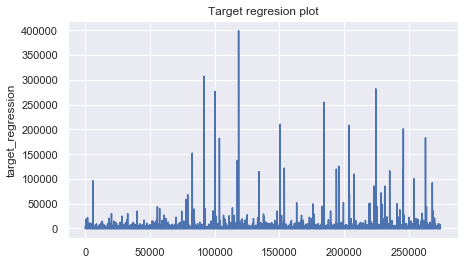

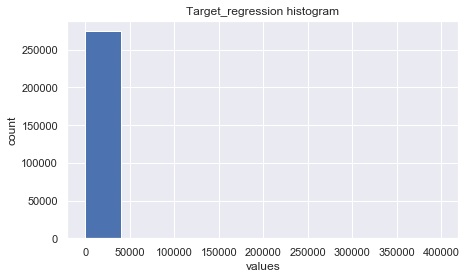

count    274582.000000
mean         78.884750
std        1923.989159
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      399213.660000
Name: target_regression, dtype: float64

In [496]:
# We see disbalanced values
pl = sns.lineplot(x=task1_train.index,y=task1_train['target_regression'])
pl.set_title('Target regresion plot')
plt.show()

plt.hist(task1_train['target_regression'])
plt.title('Target regression histogram')
plt.xlabel('values')
plt.ylabel('count')
plt.show()

task1_train['target_regression'].describe()

In [497]:
# Divide data into train and val datasets
task1_train_regression = task1_train
X_train, X_val, y_train, y_val = train_test_split(task1_train_regression.iloc[:,0:-2], task1_train_regression['target_regression'], test_size=0.2)
print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
X_train.head()

Train data shape:  (219665, 46)
Validation data shape:  (54917, 46)


,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,...,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
22060,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,-0.000195,-1.239098,1.105786,-0.629457,-0.659192,-0.414123
46561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,-0.863356,0.304730,-0.195775,-0.629457,-0.659192,-0.411073
126976,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1.365694,2.363168,0.362037,-0.927615,-0.591963,-0.212355
62210,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.544920,-0.209879,-0.009838,-0.182220,1.357673,0.181270
35031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1.365694,0.304730,-0.939524,-0.554918,2.029961,-0.203715


In [499]:
# Further, we will use special method to get higher performance on disbalanced data
from sklearn.metrics.pairwise import cosine_similarity

# We are going to use the SMOTER algorithm

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = o // 100 # the number of new cases to generate
    for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}          
            for a in D.columns:
                # skip target column
                if a == target:
                    continue;
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            new_cases = new_cases.append(attr,ignore_index = True)
                    
    return new_cases

def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]  
    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
    
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D

In [500]:
# It takes much time to execute this block. Actually, it is optional!
cols = X_train.columns.tolist()
cols.append('target_regression')
D = task1_train_regression.drop(columns='target_classification')
np.random.seed(43)
# Generate new train dataset 
Xs = SmoteR(D, target='target_regression', th = 0.999, o = 300, u = 100, k = 10)

In [502]:
X_train_new = Xs.drop(columns=['target_regression'])
y_train_new = Xs[['target_regression']]
print('Train dataset shape: ', X_train.shape)

Train dataset shape:  (294634, 46)


In [503]:
# Random Forest regressor to train a model
RF_model = RandomForestRegressor(200,min_samples_leaf=4)
RF_model.fit(X_train, y_train)

# Here we make a prediction of the train data to estimate our model
RF_prediction = RF_model.predict(X_train)
print('Scores for train data:')
print('Root mean squared error: ', MSE(y_train, RF_prediction, squared=False))

print('\nScores for validation data:')
RF_prediction = RF_model.predict(X_val)
print('Root mean squared error: ', MSE(y_val, RF_prediction, squared=False))

C:\Users\r_mam\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Scores for train data:
Root mean squared error:  1863.2069473865004

Scores for validation data:
Root mean squared error:  2532.1094796256984


In [504]:
# Random Forest regressor to train a model
RF_model = RandomForestRegressor(200,min_samples_leaf=4)
RF_model.fit(X_train_new, y_train_new)

# Here we make a prediction of the train data to estimate our model
RF_prediction = RF_model.predict(X_train_new)
print('Scores for train data:')
print('Root mean squared error: ', MSE(y_train_new, RF_prediction, squared=False))

print('\nScores for validation data:')
RF_prediction = RF_model.predict(X_val)
print('Root mean squared error: ', MSE(y_val, RF_prediction, squared=False))

C:\Users\r_mam\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Scores for train data:
Root mean squared error:  1861.212908200281

Scores for validation data:
Root mean squared error:  2530.0191725428244


In [507]:
# Linear Regression to train a model
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

# Here we make a prediction of the train data to estimate our model
LR_prediction = LR_model.predict(X_train)
print('Scores for train data:')
print('Root mean squared error: ', MSE(y_train, LR_prediction, squared=False))

print('\nScores for validation data:')
LR_prediction = LR_model.predict(X_val)
print('Root mean squared error: ', MSE(y_val, LR_prediction, squared=False))

Scores for train data:
Root mean squared error:  2327.054672919986

Scores for validation data:
Root mean squared error:  2637.563324992521


In [508]:
# Linear Regression to train a model
LR_model = LinearRegression()
LR_model.fit(X_train_new, y_train_new)

# Here we make a prediction of the train data to estimate our model
LR_prediction = LR_model.predict(X_train_new)
print('Scores for train data:')
print('Root mean squared error: ', MSE(y_train_new, LR_prediction, squared=False))

print('\nScores for validation data:')
LR_prediction = LR_model.predict(X_val)
print('Root mean squared error: ', MSE(y_val, LR_prediction, squared=False))

Scores for train data:
Root mean squared error:  2327.054672919986

Scores for validation data:
Root mean squared error:  2637.563324992521


In [511]:
# Predict test dataset
X_test = task1_test
RF_prediction = RF_model.predict(X_test)

In [514]:
# Save results to a table
task1_to_file1 = pd.concat((task1_to_file,pd.DataFrame(RF_prediction,columns=['target_regression'])),axis=1)
task1_to_file1.to_csv('task1_solved.csv', sep=';')
task1_to_file1.head(100)

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,target_classification,target_regression
0,1909726,0.470000,E,7.0,10.0,38.0,54.0,B1,Regular,9307.0,R82,0,148.347739
1,2019835,0.500000,C,10.0,2.0,36.0,50.0,B10,Diesel,198.0,R11,0,8.998597
2,969514,1.000000,D,10.0,3.0,42.0,50.0,B14,Diesel,530.0,R24,1,145.175724
3,715306,0.920000,C,6.0,14.0,41.0,50.0,B1,Diesel,186.0,R24,0,84.644033
4,1204421,1.000000,D,9.0,2.0,56.0,50.0,B12,Regular,531.0,R31,1,50.666114
5,1570157,0.170000,B,5.0,13.0,27.0,50.0,B2,Diesel,72.0,R24,0,18.279636
6,626463,0.760000,C,4.0,0.0,56.0,50.0,B2,Regular,359.0,R53,1,62.243169
7,799414,0.530000,C,8.0,3.0,40.0,50.0,B4,Regular,213.0,R91,0,31.543171
8,119085,0.008219,A,8.0,1.0,46.0,50.0,B12,Diesel,41.0,R91,0,5.327681
9,1000679,1.000000,D,11.0,11.0,53.0,50.0,B10,Diesel,1403.0,R93,1,290.088018


## 1.2.1. Clustering

In [517]:
# Load dataset
task2_data = pd.read_csv('task2_v5.csv', sep=';')

# To check everything is fine
print(task2_data.head())
print(task2_data.dtypes)
task2_data.describe()

      stat_1     stat_2     stat_3     stat_4
0  -1.644344 -23.710424 -10.591175 -19.352089
1   7.463911  -9.787539  -6.299809  11.091527
2  11.536239 -12.075189 -14.095199  10.378562
3  -4.759128  -9.926430 -22.051245 -22.581364
4   9.161899  -4.731807 -11.386896  13.145629
stat_1    float64
stat_2    float64
stat_3    float64
stat_4    float64
dtype: object


,stat_1,stat_2,stat_3,stat_4
count,870.000000,870.000000,870.000000,870.000000
mean,4.485668,-1.647762,-6.645185,2.171082
std,10.300048,9.332358,10.554579,13.991237
min,-26.763733,-23.710424,-35.646614,-46.211830
25%,-3.138571,-9.511255,-14.666532,-9.024323
50%,8.555931,-2.457642,-9.721317,5.442491
75%,12.298427,5.958367,3.147081,13.505199
max,22.619133,28.107076,24.485290,21.908146


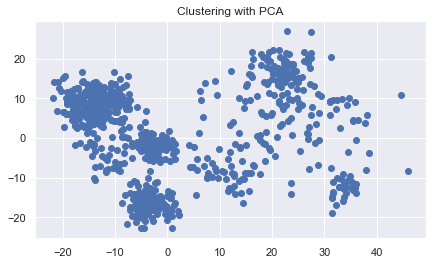

In [518]:
# Using PCA for separation
X_train = task2_data

pca = decomposition.PCA(n_components=2)
X_centered = X_train - X_train.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('Clustering with PCA')
plt.show()

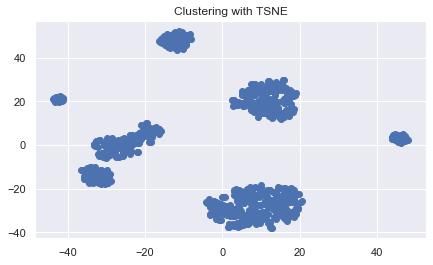

In [519]:
# Using TSNE for separation. Here 7 clusters can be seed while with PCA not
tsne = TSNE()
X_tsne = tsne.fit_transform(X_train)

plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.title('Clustering with TSNE')
plt.show()

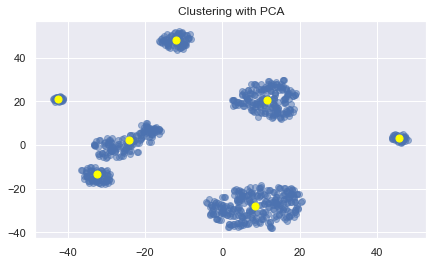

In [527]:
# Trying KMeans on X_tsne dataset. We see that clusters match theris centroids well
kmeans = KMeans(n_clusters=7).fit(X_tsne)

plt.scatter(X_tsne[:,0], X_tsne[:,1],c='b',alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='yellow',s=50)
plt.title('Clustering with PCA')
plt.show()

In [253]:
# Trying different algorithms to get labels for samples
kmeans = KMeans(n_clusters=7).fit(X_train)
affine = AffinityPropagation().fit(X_train)
spec = SpectralClustering(n_clusters=7, affinity='nearest_neighbors').fit(X_train)
agglo = AgglomerativeClustering(n_clusters=7).fit(X_train)

# Model estimation using Silhouette score
print('Scores: ')
print('KMeans: ', silhouette_score(X_train, kmeans.labels_))
print('AffinityPropagation: ', silhouette_score(X_train, affine.labels_))
print('SpectralClustering: ', silhouette_score(X_train, spec.labels_))
print('AgglomerativeClustering: ', silhouette_score(X_train, agglo.labels_))

Scores: 
KMeans:  0.5977722035734843
AffinityPropagation:  0.3946096111971045
SpectralClustering:  0.5927244810253866
AgglomerativeClustering:  0.59067443248509


C:\Users\r_mam\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


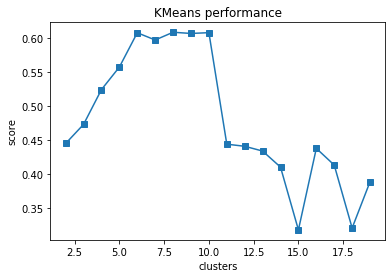

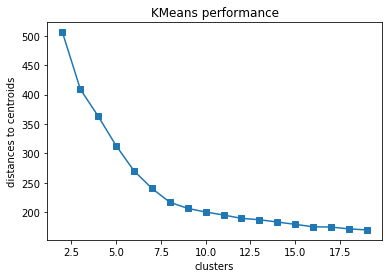

In [234]:
# To make sure that chosen number of clusters is optimal
score = []
inertia = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k).fit(X_train)
    score.append(silhouette_score(X_train, kmeans.labels_))
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(range(2,20),score,marker='s')
plt.title('KMeans performance')
plt.xlabel('clusters')
plt.ylabel('score')
plt.show() 

plt.plot(range(2,20),inertia,marker='s')
plt.title('KMeans performance')
plt.xlabel('clusters')
plt.ylabel('distances to centroids')
plt.show() 

In [529]:
# Save labels to a file
kmeans = KMeans(n_clusters=7).fit(X_train)
task2_to_file = pd.concat((task2_data, pd.DataFrame(kmeans.labels_,columns=['target_clustering'])),axis=1)
task2_to_file.to_csv('task2_solved.csv', sep=';')
task2_to_file.head(100)

,stat_1,stat_2,stat_3,stat_4,target_clustering
0,-1.644344,-23.710424,-10.591175,-19.352089,2
1,7.463911,-9.787539,-6.299809,11.091527,3
2,11.536239,-12.075189,-14.095199,10.378562,3
3,-4.759128,-9.926430,-22.051245,-22.581364,2
4,9.161899,-4.731807,-11.386896,13.145629,3
5,-14.783085,4.031125,-1.427837,-30.710038,6
6,-6.799479,-13.731187,-18.386657,-19.942205,2
7,9.292495,5.578233,-4.081763,-5.213240,4
8,-5.091978,-20.147212,-15.481381,-19.260655,2
9,-0.750755,10.928079,1.482651,-7.728952,4


**Доп. Вопросы:**
3. дополнительный вопрос на подумать (к каждой задаче): есть ли метрики, которые лучше подходят для задачи?
    
    -Для задачи классификации в случае несбалансированных данных подойдут следующие метрики: f1, precision, recall, confusion matrix,
 т.к. они показывают ошибки 1, 2 рода. В случае предложенного выше датасета имеются несбалансированные целевые значения,
поэтому модель может обучиться угадывать только превалирующие значения, а все остальные игнорировать. Таким образом,
доля правильных предсказаний будет в основном состоять из предсказаний одного наибольшего класса, и это доля будет большой,
но фактически модель нерабочая.
Для задачи регресси можно так же использовать MAE и MSE. MSE чувствительна к аномально большим значениям, поэтому может быть полезна
для нашего датасета.
4. дополнительное вопрос на подумать (к каждой задаче): как изменилось бы решение, если бы модель необходимо было встроить в другую систему, используя Java?
   
   1.Создать pipeline(preprocessing,training), затем, вместе с обученной моделью сохранить в файлы с помощью модулей pickle/JSON
   2.С помощью интерфейса Java Serializable сделать десериализацию
   3.В Python для взаимодействия сервис-клиент можно использовать Flask/Django


  